In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy 
import theano
from sklearn.metrics import mean_squared_error
from pymc3.ode import DifferentialEquation
from scipy.integrate import odeint
from random import seed
import scipy.optimize as opt
plt.style.use("seaborn-darkgrid")
from pymc3.distributions.timeseries import EulerMaruyama
import datetime
import pandas as pd
import plotly.express as px
px.defaults.height=600

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
Totales_Nacionales_Diarios = pd.read_csv("https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto5/TotalesNacionales.csv",index_col=0)

In [3]:
Total_poblacional = pd.read_csv("https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto1/Covid-19.csv",index_col=0)

Total_poblacional['Poblacion'].isna().sum()

16

In [4]:
len(Total_poblacional)-16

346

In [5]:
Total_poblacional=int(Total_poblacional['Poblacion'].sum())
Total_poblacional

19458310

In [6]:
df = Totales_Nacionales_Diarios.T

In [7]:
columnas_a = [
'Casos nuevos con sintomas'  
,'Casos totales'  
,'Casos recuperados'  
,'Fallecidos'  
,'Casos activos' 
,'Casos nuevos sin sintomas' 
,'Casos nuevos totales' 
,'Casos activos por FD' 
,'Casos activos por FIS' 
,'Casos recuperados por FIS' 
,'Casos recuperados por FD' 
,'Casos confirmados recuperados' 
,'Casos activos confirmados' 
,'Casos probables acumulados' 
,'Casos activos probables' 
,'Casos nuevos sin notificar' 
,'Casos confirmados por antigeno' 
,'Casos con sospecha de reinfeccion' 
,'Casos nuevos confirmados por antigeno' 
,'Fallecidos confirmados totales' 
,'Fallecidos sospechosos probables u otros totales' 
]

In [8]:
new = df[['Casos totales','Casos nuevos totales','Casos activos confirmados','Casos confirmados recuperados']].copy()
new=new/Total_poblacional
new.tail(10)

Fecha,Casos totales,Casos nuevos totales,Casos activos confirmados,Casos confirmados recuperados
2022-11-27,0.252328,0.000210,0.000672,0.247730
2022-11-28,0.252479,0.000145,0.000573,0.247972
2022-11-29,0.252598,0.000118,0.000471,0.248193
2022-11-30,0.252849,0.000245,0.000505,0.248407
2022-12-01,0.253108,0.000245,0.000561,0.248599
2022-12-02,0.253336,0.000220,0.000624,0.248758
2022-12-03,0.253543,0.000198,0.000659,0.248924
2022-12-04,0.253724,0.000172,0.000566,0.249189
2022-12-05,0.253840,0.000114,0.000471,0.249398
2022-12-06,0.253939,0.000094,0.000387,0.249581


In [9]:
new['Casos activos confirmados'].min()

0.00014955050053164947

In [10]:
new['Casos activos confirmados'].max()

0.0075933110326641936

In [11]:
Recuperados_diarios=new.diff()
Recuperados_diarios=Recuperados_diarios['Casos confirmados recuperados']
new['Recuperados diarios']=Recuperados_diarios

In [12]:
filtered_df=new.loc['2020-03-18':'2021-09-30']
filtered_df

Fecha,Casos totales,Casos nuevos totales,Casos activos confirmados,Casos confirmados recuperados,Recuperados diarios
2020-03-18,0.000012,0.000002,NaN,NaN,NaN
2020-03-19,0.000018,0.000005,NaN,NaN,NaN
2020-03-20,0.000022,0.000005,NaN,NaN,NaN
2020-03-21,0.000028,0.000005,NaN,NaN,NaN
2020-03-22,0.000032,0.000005,NaN,NaN,NaN
...,...,...,...,...,...
2021-09-26,0.084887,0.000040,0.000231,0.082585,0.000024
2021-09-27,0.084918,0.000033,0.000233,0.082612,0.000027
2021-09-28,0.084940,0.000023,0.000198,0.082668,0.000056
2021-09-29,0.084972,0.000027,0.000207,0.082690,0.000022


In [13]:
filtered_df_p1=new.loc['2020-07-01':'2020-10-31']
filtered_df_p1['S(t)']=1-filtered_df_p1['Casos activos confirmados']

filtered_df_p2=new.loc['2020-11-01':'2021-02-28']
filtered_df_p2['S(t)']=1-filtered_df_p2['Casos activos confirmados']

filtered_df_p3=new.loc['2021-03-01':'2021-06-30']
filtered_df_p3['S(t)']=1-filtered_df_p3['Casos activos confirmados']

filtered_df_p4=new.loc['2021-07-01':'2021-10-31']
filtered_df_p4['S(t)']=1-filtered_df_p4['Casos activos confirmados']

filtered_df_p5=new.loc['2021-11-01':'2022-02-28']
filtered_df_p5['S(t)']=1-filtered_df_p5['Casos activos confirmados']

filtered_df_total=new.loc['2020-07-01':'2022-03-01']
filtered_df_total['S(t)']=1-filtered_df_total['Casos activos confirmados']


C:\Users\sebas\AppData\Local\Temp\ipykernel_13500\1776581783.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_p1['S(t)']=1-filtered_df_p1['Casos activos confirmados']
C:\Users\sebas\AppData\Local\Temp\ipykernel_13500\1776581783.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_p2['S(t)']=1-filtered_df_p2['Casos activos confirmados']
C:\Users\sebas\AppData\Local\Temp\ipykernel_13500\1776581783.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [14]:
fig = px.line(filtered_df_total, x=filtered_df_total.index, y=['Casos activos confirmados', 'S(t)'])
newnames = {'Casos activos confirmados': "I(t)", 'S(t)': "S(t)"}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])))

fig.update_layout(title='Casos Activos Confirmados, Períodos',xaxis_title='Tiempo',yaxis_title='Proporción poblacional')
fig.add_vline(x='2020-10-31', line_width=3, line_dash="dash", line_color="orange")
fig.add_vline(x='2021-02-28', line_width=3, line_dash="dash", line_color="brown")
fig.add_vline(x='2021-06-30', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2021-10-31', line_width=3, line_dash="dash", line_color="red")
fig.add_vline(x='2022-02-28', line_width=3, line_dash="dash", line_color="purple")

fig.show()

In [15]:
# cambiar los valores numericos con el periodo de estudio
periodo_t = "3"
periodo = filtered_df_p3

In [16]:
fig = px.line(periodo, x=periodo.index, y=['Casos activos confirmados', 'S(t)'])
newnames = {'Casos activos confirmados': "I(t)", 'S(t)': "S(t)"}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])))

fig.update_layout(title='Casos Activos Confirmados, Período'+periodo_t,xaxis_title='Tiempo',yaxis_title='Proporción poblacional')

fig.show()

In [17]:
periodo.index.names = ['Fecha_indice']
periodo=periodo.reset_index()
periodo

Fecha,Fecha_indice,Casos totales,Casos nuevos totales,Casos activos confirmados,Casos confirmados recuperados,Recuperados diarios,S(t)
0,2021-03-01,0.042643,0.000210,0.001257,0.040302,0.000189,0.998743
1,2021-03-02,0.042784,0.000141,0.001219,0.040481,0.000179,0.998781
2,2021-03-03,0.042941,0.000157,0.001229,0.040627,0.000145,0.998771
3,2021-03-04,0.043175,0.000235,0.001287,0.040796,0.000169,0.998713
4,2021-03-05,0.043449,0.000274,0.001404,0.040949,0.000153,0.998596
...,...,...,...,...,...,...,...
117,2021-06-26,0.079279,0.000268,0.001562,0.076000,0.000334,0.998438
118,2021-06-27,0.079509,0.000231,0.001496,0.076287,0.000286,0.998504
119,2021-06-28,0.079716,0.000209,0.001431,0.076550,0.000263,0.998569
120,2021-06-29,0.079851,0.000136,0.001320,0.076794,0.000244,0.998680


In [18]:
# NOTA: fijar el seed SOLAMENTE si se estan probando diferentes modelos
# seed(2418)

# From now on we'll work with proportions instead of integer numbers
# i -> infectados/N
# Parameters: 
# beta = disease transmission rate
# gamma = recovery rate
# mu = mortality rate
# mu + beta = renewal rate
# theta = [beta - (mu+gamma), beta]
# Thus, if theta[0]<0, the disease will vanish and if theta[0]>0 we have persistence of the disease

i0 = periodo['Casos activos confirmados'][0] #0.2 # initial proportion of infected
Tf = len(periodo['Casos activos confirmados']) #20  # Terminal time
T0 = 0 # Initial time
Dt = 1 # time step

times = np.arange(T0, Tf, Dt) # time vector

In [19]:
infected_obs=np.array(periodo['Casos activos confirmados'])

Text(0, 0.5, 'Proporción')

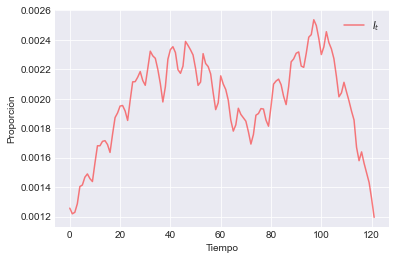

In [20]:
plt.plot(infected_obs, "r", label=r"$I_t$", alpha=0.5)
plt.xlabel("Tiempo")
plt.legend()
plt.ylabel("Proporción")

In [21]:
# ODEs model
def SISS(i, theta):
    di = (i[0]*(theta[0]-theta[1]*i[0])) 
    sigma1 =  theta[2] *( i[0]-i[0]**2)
    return di, sigma1

In [22]:
simga_2_ep = sum(np.diff(infected_obs)**2)/(Dt*sum((infected_obs**2)*(1-infected_obs)**2))
simga_ep=np.sqrt(simga_2_ep)
simga_ep

0.04159972328052121

In [23]:
# Define pymc model and sampling the MC Markov chain
nb_chains = 2 #choose >1 to run some convergence diagnostics on the chains
len_chains = 15000
len_burning_states = 5000

In [24]:
with pm.Model() as model:
    theta_m = [0,0,0]
    theta_m[0] = pm.Normal("beta-(mu+gamma)",0,1) 
    theta_m[1] = pm.Gamma("beta", 3,1)
    theta_m[2] = pm.HalfNormal("sigma",1) 
    eu = EulerMaruyama("EM", Dt, SISS, (theta_m,),shape=infected_obs.shape, observed=infected_obs)


In [25]:
with model:
    trace = pm.sample(len_chains, tune=len_burning_states, cores=1, chains=nb_chains, start={"sigma":simga_ep})
    data = az.from_pymc3(trace=trace)

C:\Users\sebas\AppData\Local\Temp\ipykernel_13500\2817667489.py:2: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, beta-(mu+gamma)]


Sampling 2 chains for 5_000 tune and 15_000 draw iterations (10_000 + 30_000 draws total) took 20 seconds.


WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl


There were 12 divergences after tuning. Increase `target_accept` or reparameterize.


In [26]:
a=az.summary(trace)
a

Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\sebas\anaconda3\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta-(mu+gamma),0.003,0.007,-0.009,0.016,0.000,0.000,23199.0,14769.0,1.0
beta,3.025,1.740,0.346,6.177,0.012,0.009,21068.0,17363.0,1.0
sigma,0.068,0.004,0.059,0.076,0.000,0.000,26174.0,18989.0,1.0


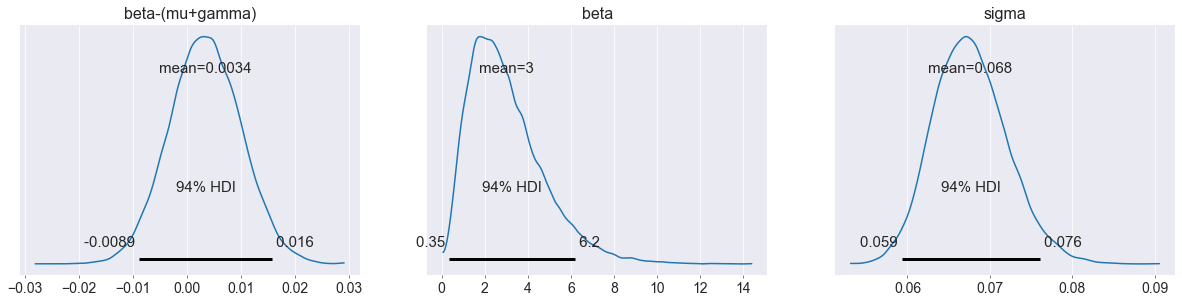

In [27]:
# Plot posterior densities
az.plot_posterior(data, 
                  var_names=["beta-(mu+gamma)", "beta","sigma"]);
plt.show()

Text(0, 0.5, 'MCMC promedio')

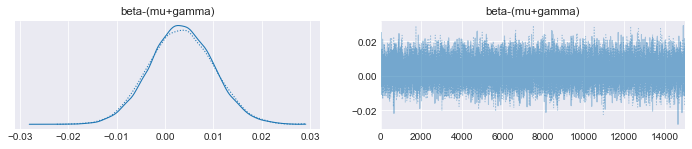

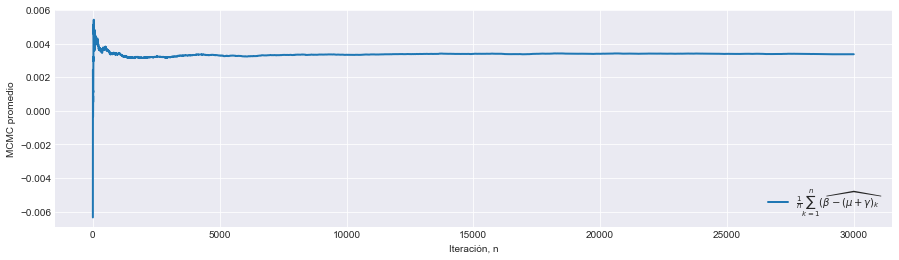

In [28]:
# plot the exploration for each chain and convergence of the ergodic mean
# beta - (mu+gamma)
az.plot_trace({"beta-(mu+gamma)": trace.get_values(varname="beta-(mu+gamma)", combine=False)})
mean_theta0 = [np.mean(trace['beta-(mu+gamma)'][:i]) for i in np.arange(1, len(trace['beta-(mu+gamma)']))]
plt.figure(figsize=(15, 4))
plt.plot(mean_theta0, lw=2, label=r"$\frac{1}{n}\sum_{k=1}^n\widehat{(\beta-(\mu+\gamma)}_k$")
plt.xlabel("Iteración, n")
plt.legend()
plt.ylabel("MCMC promedio")

Text(0, 0.5, 'MCMC promedio')

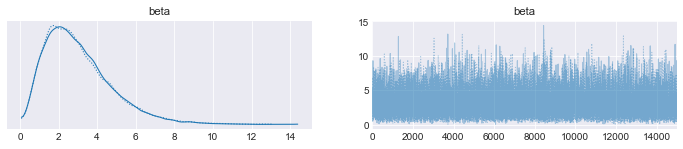

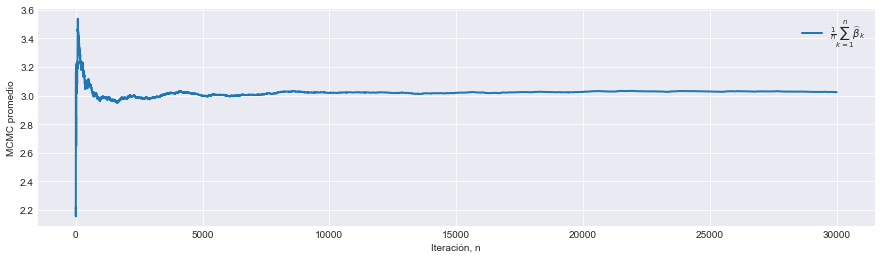

In [29]:
# beta
az.plot_trace({"beta": trace.get_values(varname="beta", combine=False)})
mean_theta1 = [np.mean(trace['beta'][:i]) for i in np.arange(1, len(trace['beta']))]
plt.figure(figsize=(15, 4))
plt.plot(mean_theta1, lw=2, label=r"$\frac{1}{n}\sum_{k=1}^n\widehat{\beta}_k$")
plt.xlabel("Iteración, n")
plt.legend()
plt.ylabel("MCMC promedio")

Text(0, 0.5, 'MCMC promedio')

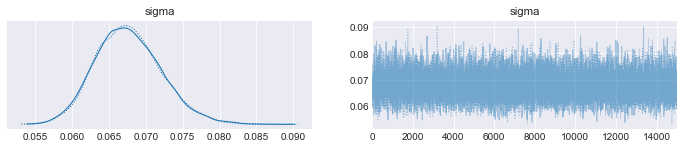

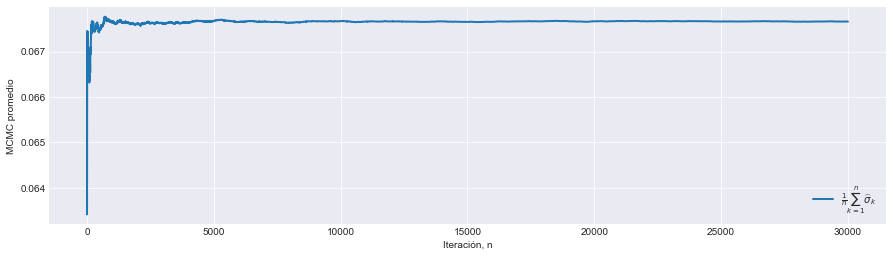

In [30]:
# sigma
az.plot_trace({"sigma": trace.get_values(varname="sigma", combine=False)})
mean_theta2 = [np.mean(trace['sigma'][:i]) for i in np.arange(1, len(trace['sigma']))]
plt.figure(figsize=(15, 4))
plt.plot(mean_theta2, lw=2, label=r"$\frac{1}{n}\sum_{k=1}^n\widehat{\sigma}_k$")
plt.xlabel("Iteración, n")
plt.legend()
plt.ylabel("MCMC promedio")

In [31]:
theta_est = [mean_theta0[-1],mean_theta1[-1],mean_theta2[-1]]

R_0 = 1+(theta_est[0]-0.5*theta_est[2]**2)/(theta_est[1]-theta_est[0])
R_0
if R_0 > 1:
    print('la enfermedad persiste')
else: 
    if theta_est[2]**2 <= theta_est[1]:
        print('la enfermedad se extingue')


if theta_est[2]**2 > theta_est[1]*max(1,(0.5*theta_est[1])/(theta_est[1]-theta_est[0])):
    print('la enfermedad se extingue')

la enfermedad persiste


In [32]:
theta_est

[0.0033748771418387847, 3.0245797172389794, 0.06765918209739495]

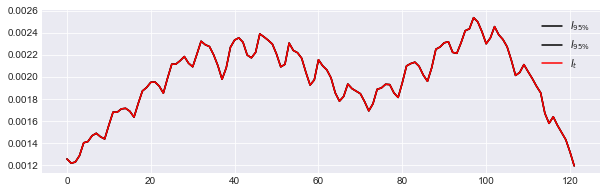

In [33]:
# generate trace from posterior
ppc_trace = pm.sample_posterior_predictive(trace, model=model)

# plot with data
plt.figure(figsize=(10, 3))
plt.plot(np.percentile(ppc_trace["EM"], [2.5, 97.5], axis=0).T, "k", label=r"$I_{95\%}$")
plt.plot(infected_obs, "r", label=r"$I_t$")
plt.legend()

In [34]:
def trayectorias(infected_obs,theta_est):
    Dt = 1 # time step
    N = len(infected_obs)-1
    i0 = infected_obs[0]
    x = i0 # initial proportion of infected 
    x_t_est = []

    # simulate
    for i in range(N):
        x = x + (x*(theta_est[0]-(x*theta_est[1])))*Dt + theta_est[2] * (x-x**2) * np.random.normal()*np.sqrt(Dt)
        x_t_est.append(x)
    x_t_est = np.array(x_t_est) # convert the values into an array
    x_t_est=np.insert(x_t_est,0,i0,axis=0) # add the initial condition at the beginning of the array
    return  x_t_est

Text(0.5, 1.0, 'Periodo 3')

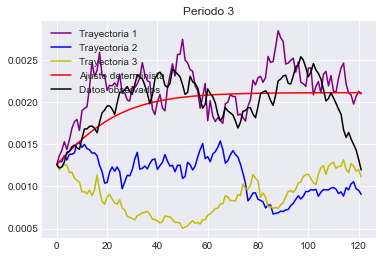

In [50]:
theta_est=[0.003386090477389625, 3.027757929224179, 0.06757162318874918]
i0 = periodo['Casos activos confirmados'][0] #0.2 # initial proportion of infected
Tf = len(periodo['Casos activos confirmados']) #20  # Terminal time
T0 = 0 # Initial time
Dt = 1 # time step
times = np.arange(T0, Tf, Dt) # time vector

# ODE solution (analytical solution computed before)
def solution_SIS(t,*param):
  aux_exp = np.exp(param[0]*t)
  aux = param[0] + param[1]*(i0)*(aux_exp - 1)
  return i0*param[0]*aux_exp/aux

theta_est_d=[0.06452942163333406, 30.562786843762275]
MCMC_model = solution_SIS(times, theta_est_d[0], theta_est_d[1])

aa=trayectorias(infected_obs,theta_est)
msr_aa=mean_squared_error(infected_obs,aa)
plt.plot(trayectorias(infected_obs,theta_est), "purple", label=r"Trayectoria 1")
plt.plot(trayectorias(infected_obs,theta_est), "b", label=r"Trayectoria 2")
plt.plot(trayectorias(infected_obs,theta_est), "y", label=r"Trayectoria 3")
plt.plot(times, MCMC_model, "r", label="Ajuste determinista")
plt.plot(infected_obs, "k", label=r"Datos observados")
plt.legend()
plt.title("Periodo 3")

Text(0.5, 1.0, 'Periodo 3, Trayectoria 1 \n error cuadratico medio: 6.31788183695702e-07')

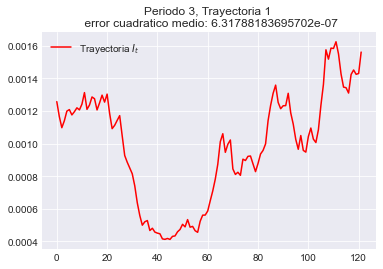

In [36]:
aa=trayectorias(infected_obs,theta_est)
msr_aa=mean_squared_error(infected_obs,aa)
plt.plot(trayectorias(infected_obs,theta_est), "r", label=r"Trayectoria $I_t$")
plt.legend()
plt.title("Periodo 3, Trayectoria 1 \n error cuadratico medio: "+ str(msr_aa))

In [37]:
mc = 10000
mse_est = []
i=0
# iterate through folder 1 to 34
    # try we are able to read the file
while i < mc:
    try :
        mse_ = mean_squared_error(infected_obs,trayectorias(infected_obs,theta_est))
        mse_est.append(mse_)
        i+=1
        # if any error occurs, skip this step and continue.
    except ValueError:
        mse_ = np.nan
        mse_est.append(mse_)
    continue
mse_est=np.mean(mse_est)
mse_est

1.036801477688136e-06

In [38]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Dec 09 2022

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.4.0

scipy     : 1.7.3
theano    : 1.1.2
arviz     : 0.12.1
pandas    : 1.4.3
plotly    : 5.10.0
pymc3     : 3.11.4
sys       : 3.10.4 | packaged by conda-forge | (main, Mar 30 2022, 08:38:02) [MSC v.1916 64 bit (AMD64)]
matplotlib: 3.5.1
numpy     : 1.22.3

Watermark: 2.3.1

